### Importing libraries

In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import variation
import operator
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [103]:
train = pd.read_csv("aps_failure_training_set.csv", skiprows = 20)
test = pd.read_csv("aps_failure_test_set.csv", skiprows = 20)

In [104]:
df = pd.concat([train, test])

### b) Data Preparation

### i) Some commonly used methods of Data Imputation are as follows:,
- *Mean Imputation*: Substitute the mean in place of the unavailble values.
- *Substitution*: Take the value from some another similar observation which was not selected as a part of the sample.
- *Hot Deck Imputation*: Randomly choose an observation and use its values to fill the missing values.
- *Cold Deck Imputation*: Systematically choose an observation and use its values to fill the missing values.
- *Regression Imputation*: Fit a regression model on the data set where values are not missing and use the model to predict the missing values for the observations wihtout the values.
- *Stochastic Regression imputation*: Same as above but also add a random residual score.
- *Interpolation and Extrapolation*: An estimated value from other observations from the same individual.

#### Imputation Technique : Mean

In [105]:
def imputation_mean(df):
    for column in df.columns:
        if column == "class":
            continue
        df[column] = df[column].replace('na', np.NaN)
        df[column] = df[column].replace(np.NaN, df[column].astype(float).mean(skipna = True))
        df[column] = df[column].astype(float)
    return df

In [106]:
df = imputation_mean(df)
train = imputation_mean(train)
#train.to_csv("train.csv")
test = imputation_mean(test)
#test.to_csv("test.csv")
train_Y = train["class"].map({"pos":1, "neg":0})
train_X = train.drop(["class"], axis = 1)
test_Y = test["class"].map({"pos":1, "neg":0})
test_X = test.drop(["class"], axis = 1)

### ii) Coefficients of Variation

In [107]:
cv = []
for col in df.columns:
    if col == "class":
        continue
    cv.append((col, np.var(df[col])/np.mean(df[col])))

In [108]:
cv

[('aa_000', 1145925.902345108),
 ('ab_000', 3.4426457238413763),
 ('ac_000', 1674788994.2308252),
 ('ad_000', 6436902722.185698),
 ('ae_000', 3348.2768222518152),
 ('af_000', 3592.9302438290356),
 ('ag_000', 1676590.4639335335),
 ('ag_001', 2133714.5556917097),
 ('ag_002', 3012655.0656705843),
 ('ag_003', 7175316.811582093),
 ('ag_004', 13439744.107447062),
 ('ag_005', 9863538.882070115),
 ('ag_006', 9222142.362270221),
 ('ag_007', 3961312.0780366845),
 ('ag_008', 1403473.1382269086),
 ('ag_009', 5438161.00253217),
 ('ah_000', 9825888.670593932),
 ('ai_000', 3286848.656095812),
 ('aj_000', 2172650.7850461253),
 ('ak_000', 5989506.066917244),
 ('al_000', 5114969.579015672),
 ('am_0', 7994773.79655356),
 ('an_000', 17800783.73081675),
 ('ao_000', 15747007.628758924),
 ('ap_000', 9706930.868428867),
 ('aq_000', 3657423.008129311),
 ('ar_000', 55.057613612935555),
 ('as_000', 3207697.443148784),
 ('at_000', 2793928.200830932),
 ('au_000', 2222710.005418502),
 ('av_000', 37627.02492824689),

### iii) Correlation Matrix

In [110]:
corr = df.corr()
corr

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
aa_000,1.000000,0.019725,-0.011658,-0.000541,0.025795,0.035994,0.011682,7.637796e-02,0.195161,0.307443,...,0.414125,0.419912,0.409659,0.419780,0.425679,0.356969,0.259668,0.133764,0.006688,1.033025e-02
ab_000,0.019725,1.000000,-0.010898,0.000066,0.024869,0.043276,0.000590,6.546741e-03,0.023484,0.035696,...,0.025161,0.037052,0.028766,0.034201,0.023921,0.013598,0.002371,0.000506,0.046897,7.568283e-02
ac_000,-0.011658,-0.010898,1.000000,-0.002030,-0.004769,-0.010612,0.015534,-2.333311e-03,-0.009439,-0.022889,...,-0.009808,-0.006437,-0.007962,-0.008115,-0.014680,-0.018631,0.010435,0.017293,-0.006191,1.582557e-02
ad_000,-0.000541,0.000066,-0.002030,1.000000,-0.000195,-0.000236,-0.000038,-3.370216e-05,-0.000093,-0.000223,...,-0.000883,-0.000921,-0.000908,-0.000730,-0.000745,-0.000462,-0.000794,-0.000500,-0.000082,-9.127097e-05
ae_000,0.025795,0.024869,-0.004769,-0.000195,1.000000,0.829986,-0.000441,-6.085608e-04,0.001948,0.020678,...,0.012751,0.019441,0.012847,0.026437,0.066533,0.036619,-0.008393,-0.006952,0.063587,3.085405e-02
af_000,0.035994,0.043276,-0.010612,-0.000236,0.829986,1.000000,-0.000539,-7.374163e-04,0.004362,0.030822,...,0.022533,0.034270,0.022000,0.042967,0.097138,0.046482,-0.010843,-0.008539,0.093474,4.436829e-02
ag_000,0.011682,0.000590,0.015534,-0.000038,-0.000441,-0.000539,1.000000,2.163319e-01,0.140260,0.079368,...,0.045941,0.051635,0.052106,0.048416,0.032208,0.007631,0.000067,-0.001103,-0.000076,1.561885e-04
ag_001,0.076378,0.006547,-0.002333,-0.000034,-0.000609,-0.000737,0.216332,1.000000e+00,0.794754,0.527426,...,0.199212,0.184646,0.202029,0.300477,0.239128,0.068003,0.005353,-0.003540,0.001140,3.653847e-03
ag_002,0.195161,0.023484,-0.009439,-0.000093,0.001948,0.004362,0.140260,7.947542e-01,1.000000,0.794945,...,0.299286,0.283578,0.305044,0.475118,0.401258,0.181967,0.009109,-0.009089,0.005625,1.341441e-02
ag_003,0.307443,0.035696,-0.022889,-0.000223,0.020678,0.030822,0.079368,5.274262e-01,0.794945,1.000000,...,0.471739,0.444714,0.451595,0.625898,0.615107,0.475570,0.020684,-0.018164,0.011036,1.060380e-02


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.MaxNLocator object at 0x150a3d828>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.MaxNLocator object at 0x150a3d828>
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


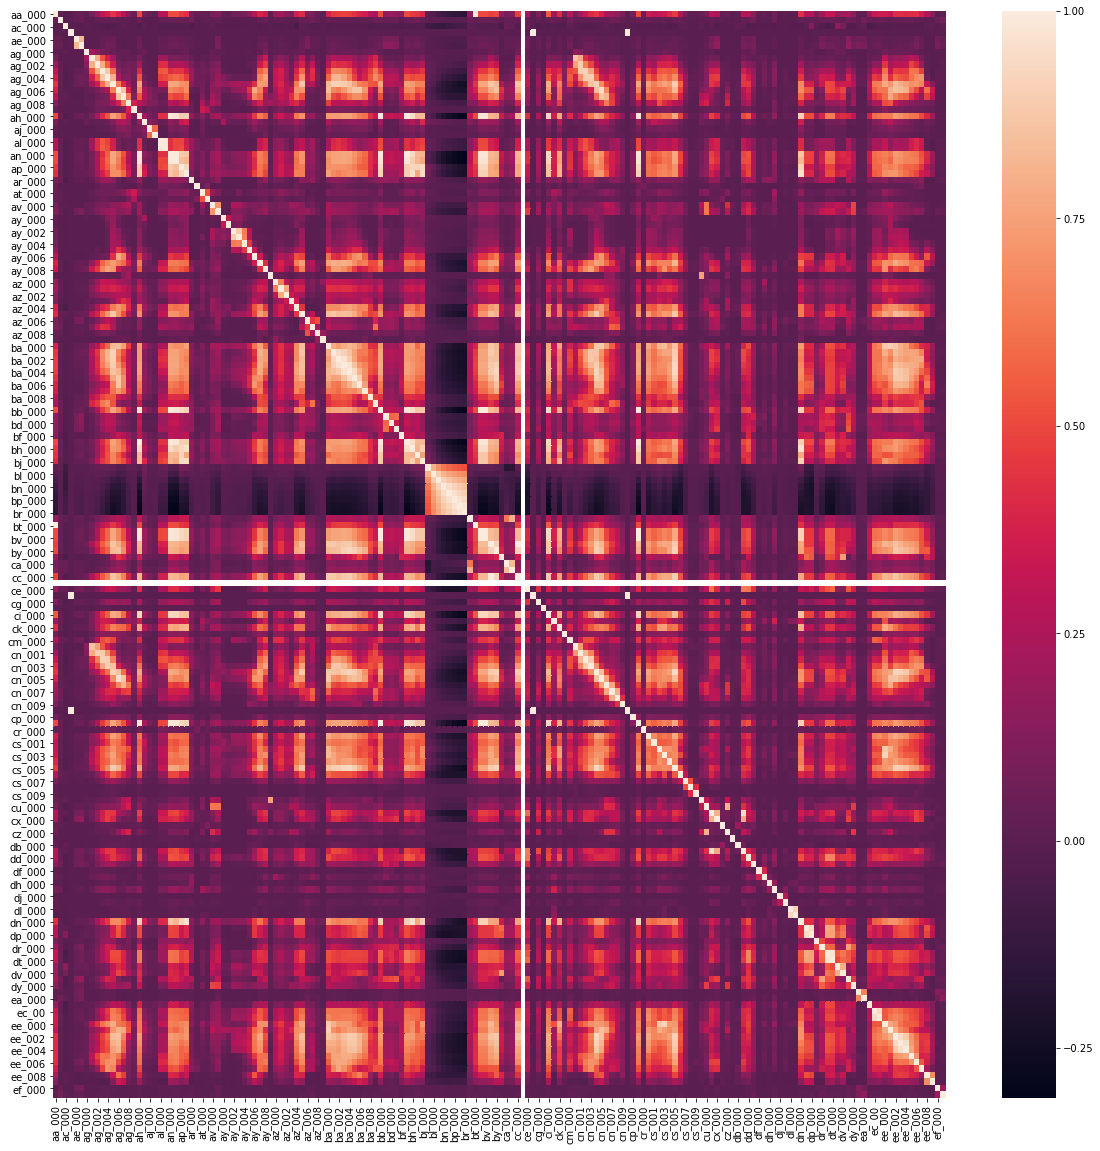

In [112]:
plt.figure(figsize = (20, 20))
sns.heatmap(corr)

### iv) Scatterplots and BoxPlots

In [11]:
featuresWithHighestCV = cv[0:int(np.sqrt(170))]
featuresWithHighestCV = [featuresWithHighestCV[i][0] for i in range(len(featuresWithHighestCV))]
featuresWithHighestCV.append("class")

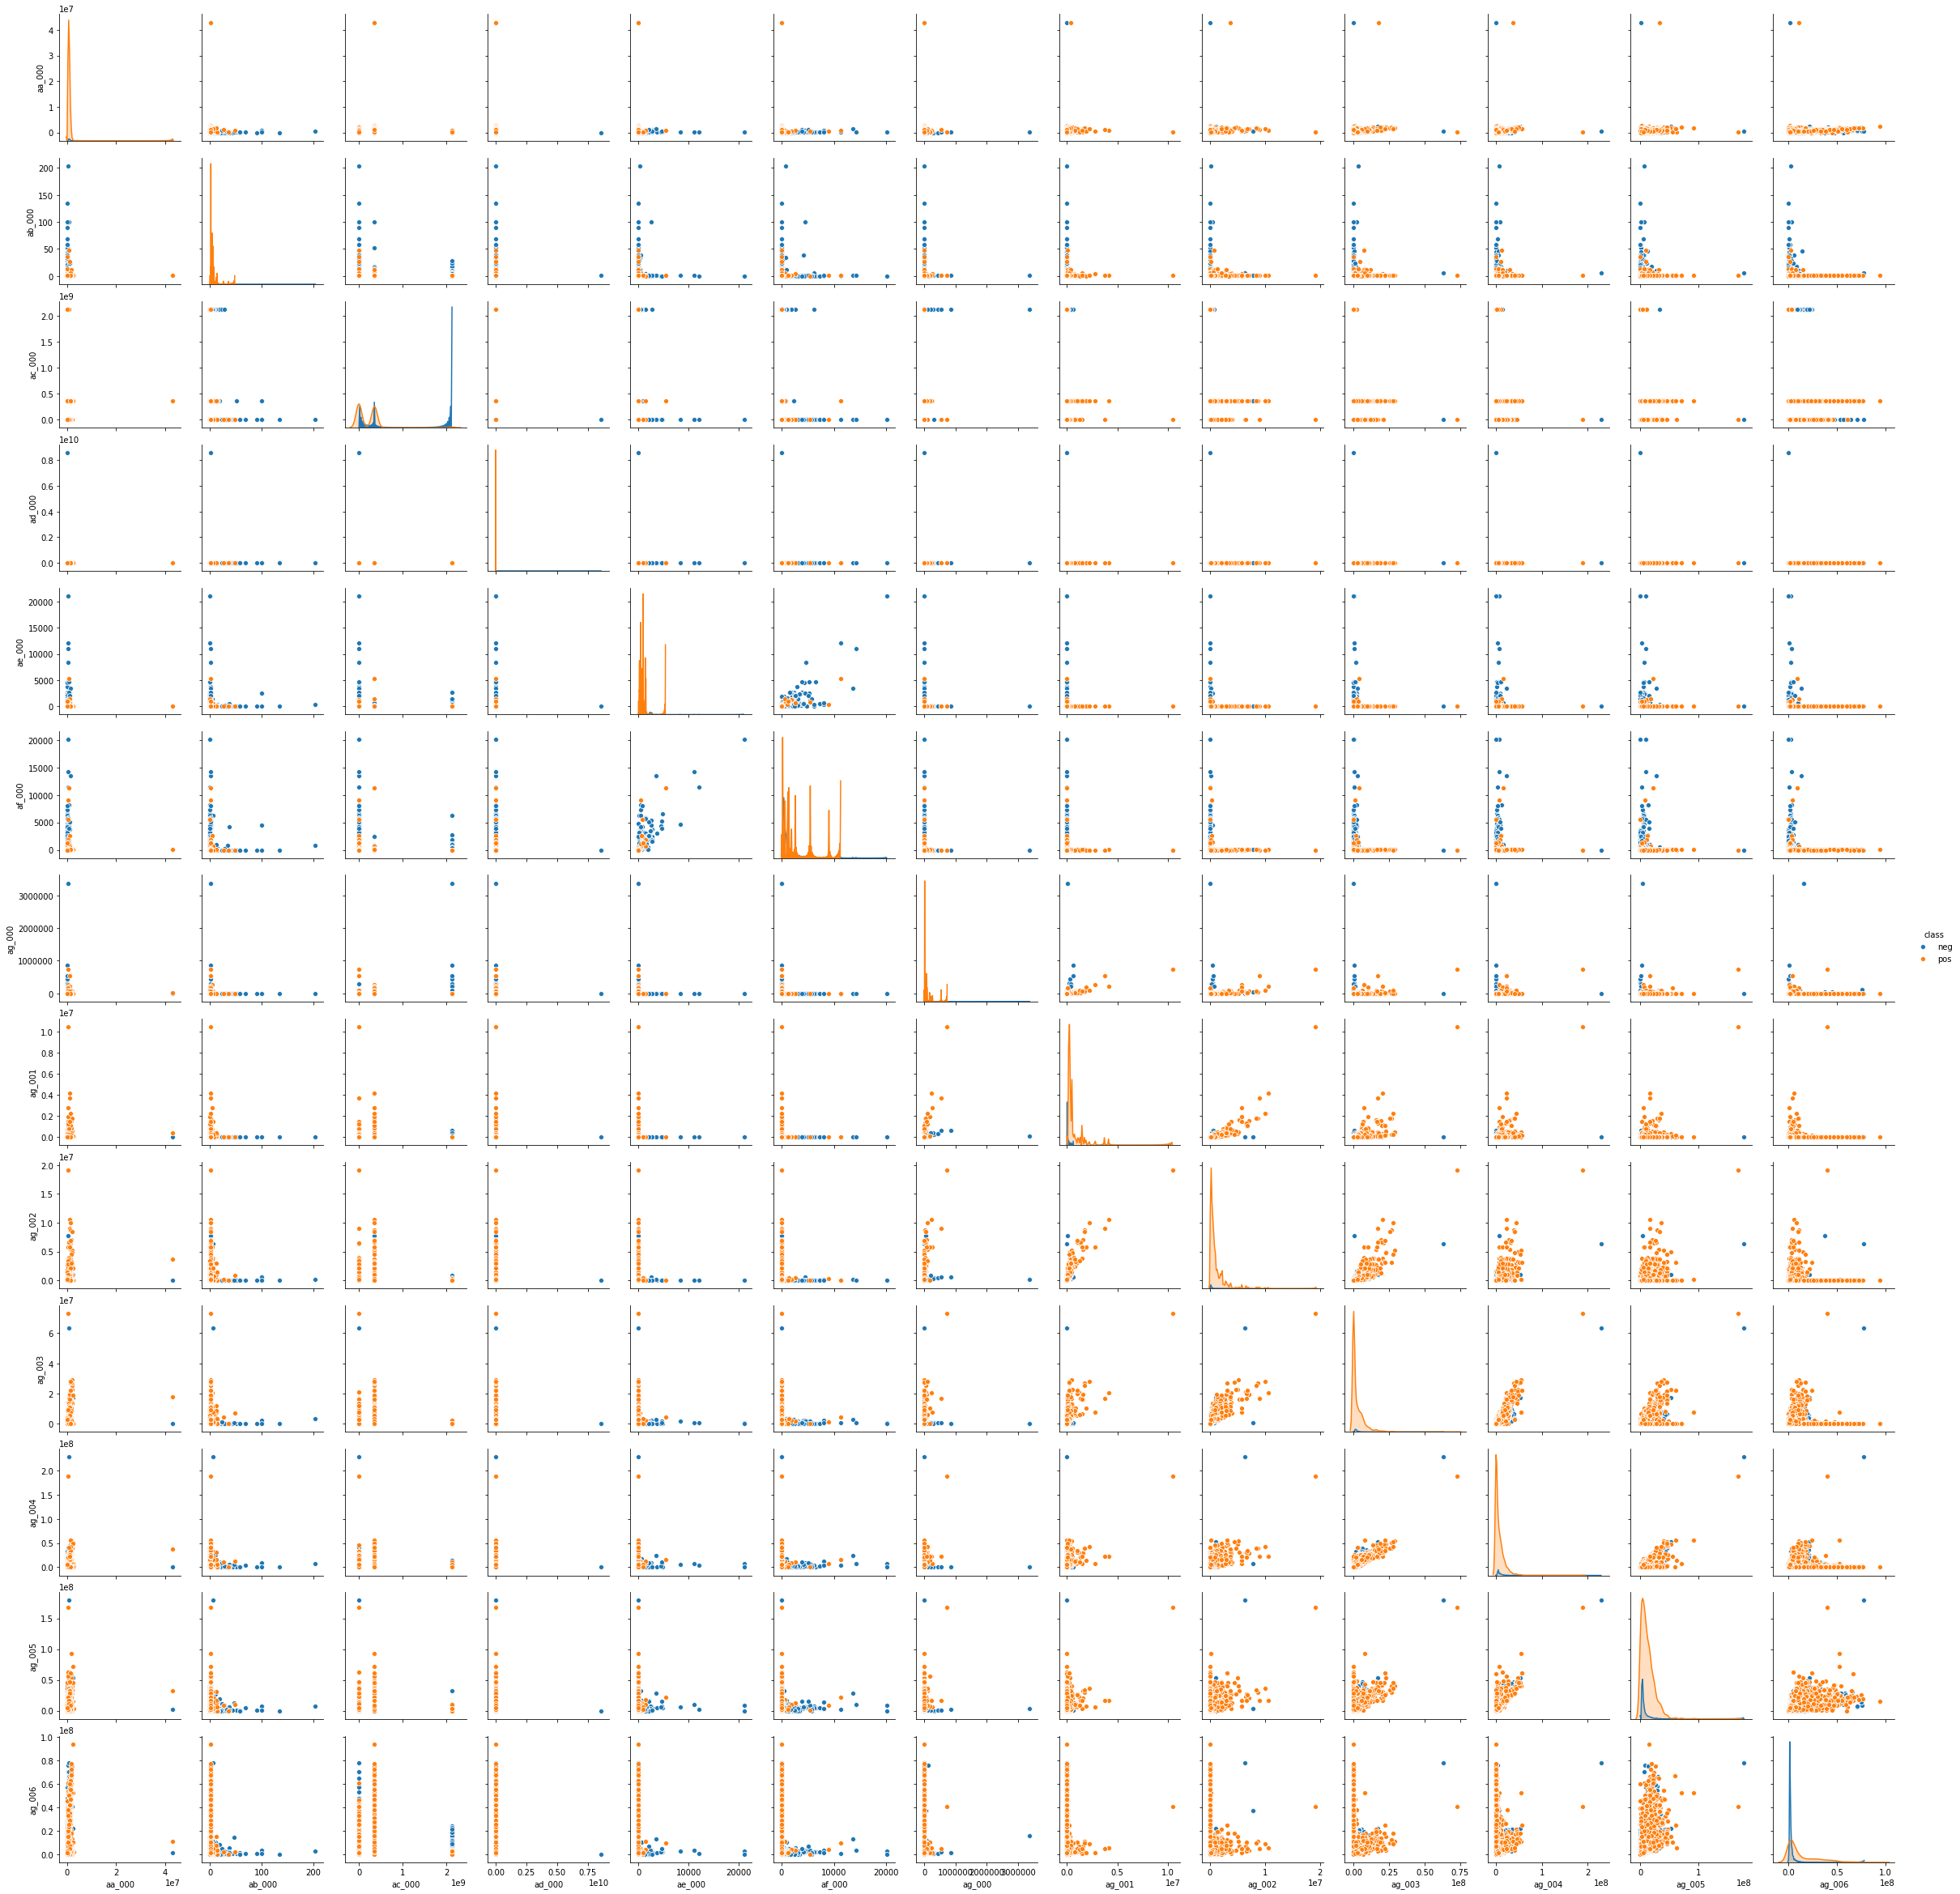

In [12]:
scatterPlotData = df[featuresWithHighestCV]
sns.pairplot(scatterPlotData, hue = "class")

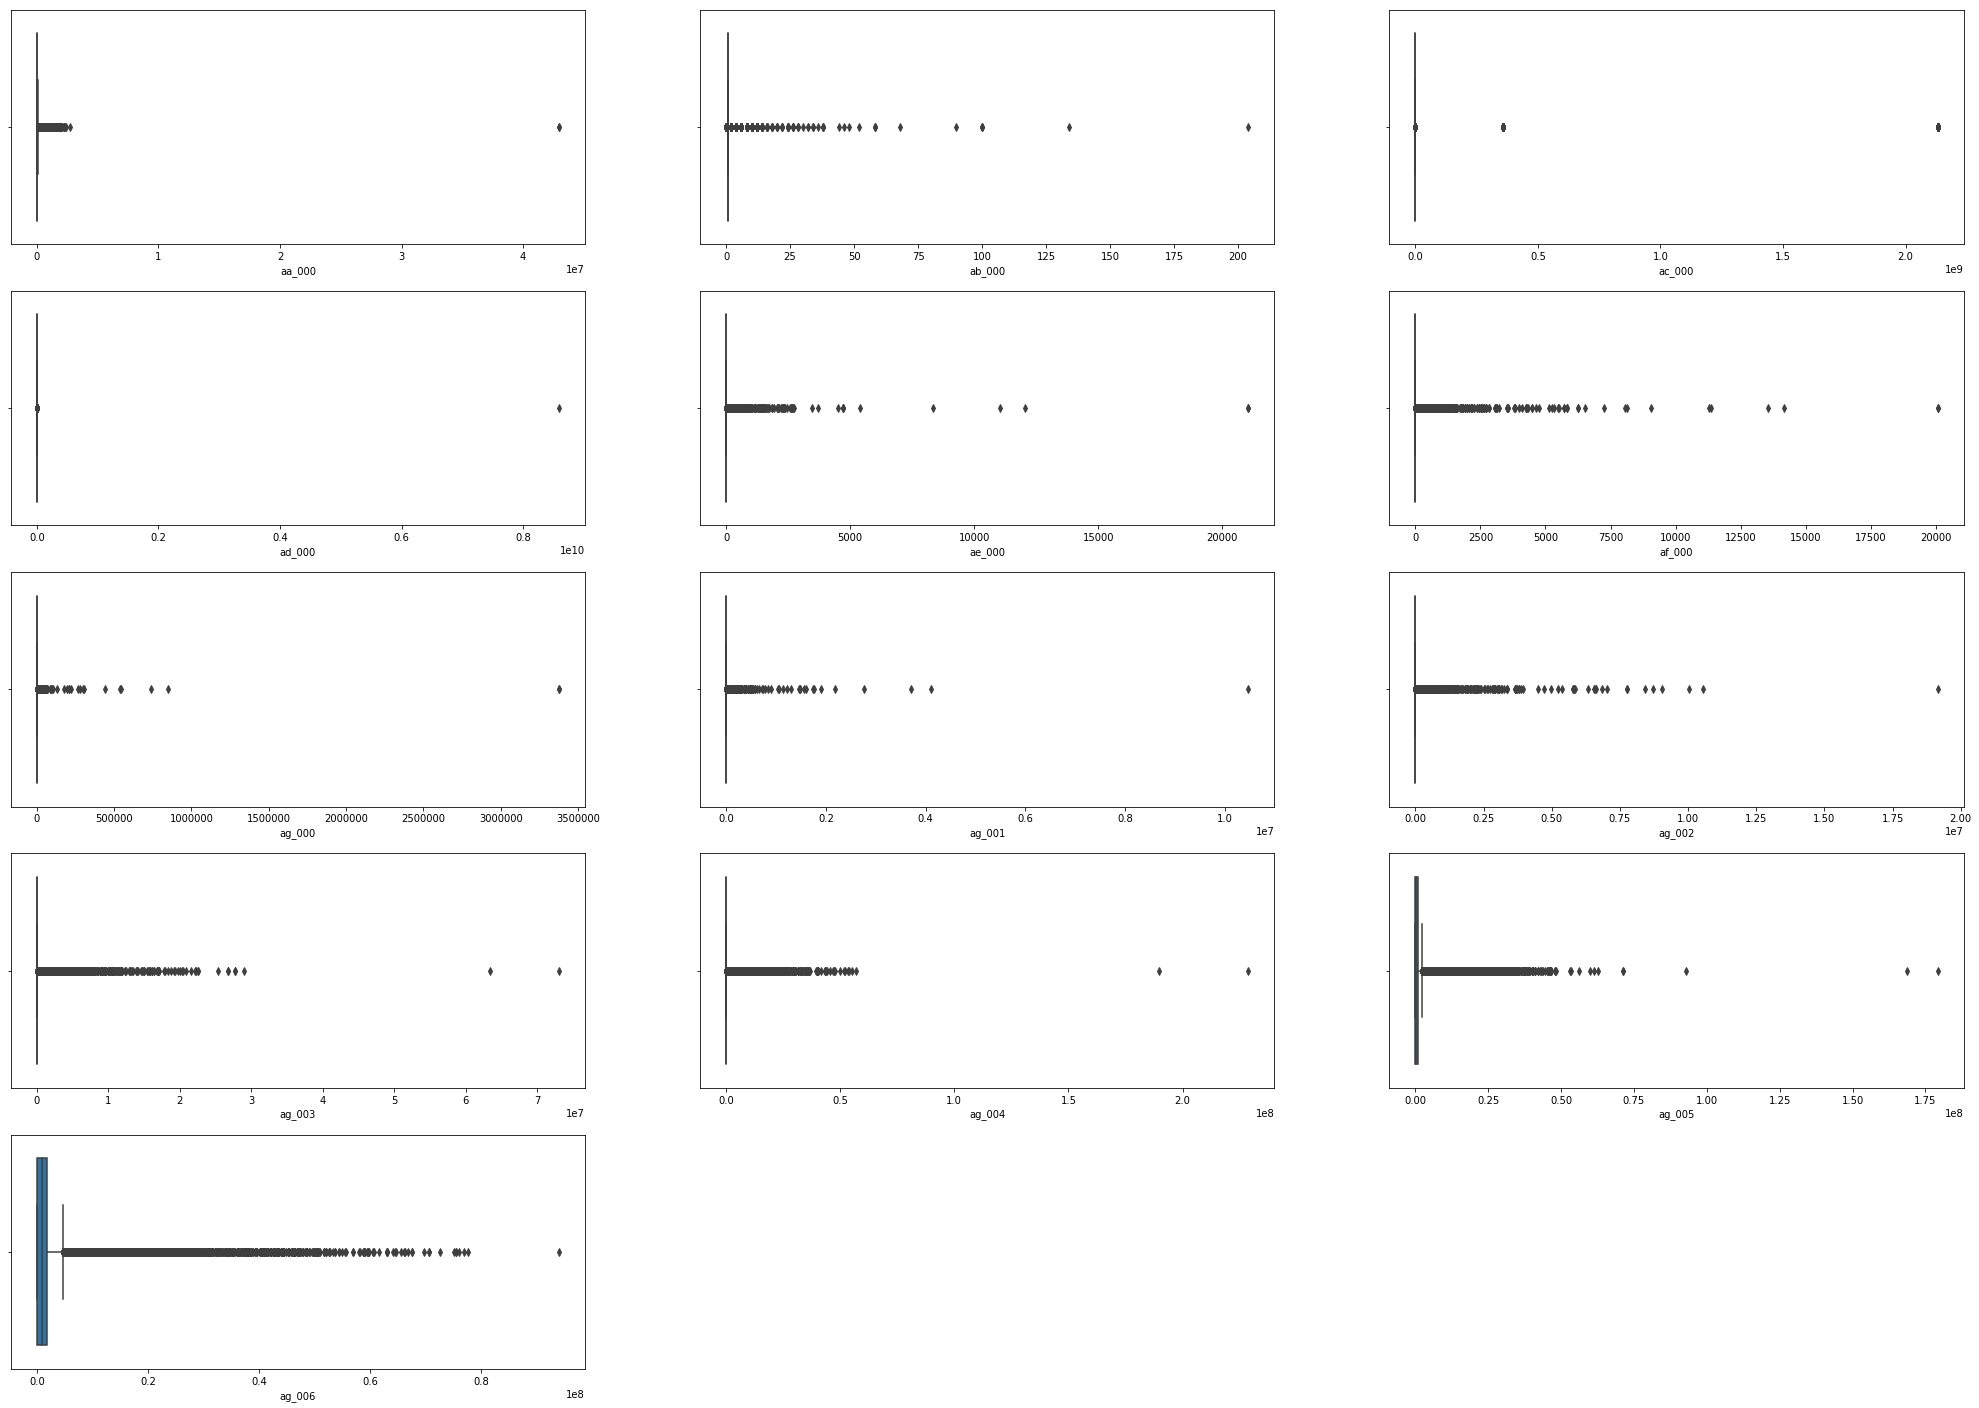

In [37]:
i = 1
plt.figure(figsize=(35,25))
for feature in featuresWithHighestCV:
    if feature == "class":
        continue
    plt.subplot(5,3,i)
    sns.boxplot(df[feature])
    i+=1

In [41]:
train["class"].value_counts()

neg    59000
pos     1000
Name: class, dtype: int64

#### Since the number of observations with negative class is 59 times the number of observations with positive class, the data is definetely imbalanced.

### c) Random Forest Classifier

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ROC AUC Score for training set:  0.9804999999999999
Confusion Matrix for training set:  [[59000     0]
 [   39   961]]
OOB Error for training set:  0.008483333333333287
MSE Error for training set:  0.00065


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


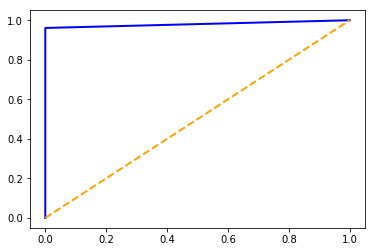

In [44]:
rf = RandomForestClassifier(oob_score = True)
rf = rf.fit(train_X, train_Y)
pred = rf.predict(train_X)
print("ROC AUC Score for training set: ", roc_auc_score(train_Y, pred))
print("Confusion Matrix for training set: ", confusion_matrix(train_Y, pred))
print("OOB Error for training set: ", 1 - rf.oob_score_)
print("MSE Error for training set: ", mean_squared_error(train_Y, pred))
fpr, tpr, _ = roc_curve(train_Y, pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color = "blue", lw = lw)
plt.plot([0, 1], [0, 1], color = "orange", lw = lw, linestyle = "--")

ROC AUC Score for test set:  0.8194560000000001
Confusion Matrix for test set:  [[15608    17]
 [  135   240]]
OOB Error for test set:  0.008483333333333287
MSE Error for test set:  0.0095


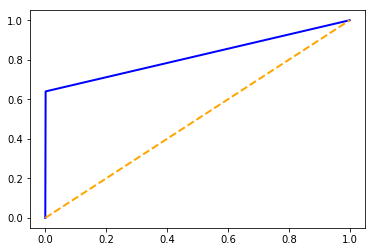

In [46]:
pred = rf.predict(test_X)
print("ROC AUC Score for test set: ", roc_auc_score(test_Y, pred))
print("Confusion Matrix for test set: ", confusion_matrix(test_Y, pred))
print("OOB Error for test set: ", 1 - rf.oob_score_)
print("MSE Error for test set: ", mean_squared_error(test_Y, pred))
fpr, tpr, _ = roc_curve(test_Y, pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color = "blue", lw = lw)#, label = "ROC for training data" auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color = "orange", lw = lw, linestyle = "--")

### d) Handling class imbalance

In [48]:
rf = RandomForestClassifier(oob_score = True, class_weight="balanced")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ROC AUC Score for training set:  0.9769915254237288
Confusion Matrix for training set:  [[58999     1]
 [   46   954]]
OOB Error for training set:  0.00996666666666668
MSE Error for training set:  0.0007833333333333334


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


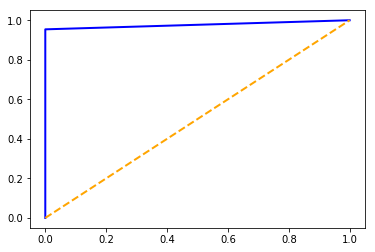

In [49]:
rf = rf.fit(train_X, train_Y)
pred = rf.predict(train_X)
print("ROC AUC Score for training set: ", roc_auc_score(train_Y, pred))
print("Confusion Matrix for training set: ", confusion_matrix(train_Y, pred))
print("OOB Error for training set: ", 1 - rf.oob_score_)
print("MSE Error for training set: ", mean_squared_error(train_Y, pred))
fpr, tpr, _ = roc_curve(train_Y, pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color = "blue", lw = lw)
plt.plot([0, 1], [0, 1], color = "orange", lw = lw, linestyle = "--")

ROC AUC Score for test set:  0.755488
Confusion Matrix for test set:  [[15609    16]
 [  183   192]]
OOB Error for test set:  0.00996666666666668
MSE Error for test set:  0.0124375


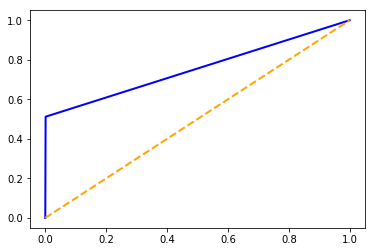

In [50]:
pred = rf.predict(test_X)
print("ROC AUC Score for test set: ", roc_auc_score(test_Y, pred))
print("Confusion Matrix for test set: ", confusion_matrix(test_Y, pred))
print("OOB Error for test set: ", 1 - rf.oob_score_)
print("MSE Error for test set: ", mean_squared_error(test_Y, pred))
fpr, tpr, _ = roc_curve(test_Y, pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color = "blue", lw = lw)#, label = "ROC for training data" auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color = "orange", lw = lw, linestyle = "--")

### e) Logistic Model Trees

In [1]:
from weka.core.converters import Loader
import weka.core.converters as convert
import weka.core.jvm as jvm
from weka.classifiers import Classifier, Evaluation, PredictionOutput
from weka.core.classes import Random
jvm.start()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/javabridge/jars/rhino-1.7R4.jar', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/javabridge/jars/runnablequeue.jar', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/javabridge/jars/cpython.jar', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/weka/lib/python-weka-wrapper.jar', '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/weka/lib/weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled
DEBUG:javabridge.jutil:Creating JVM object
DEBUG:javabridge.jutil:Launching VM in non-python thread
DEBUG:javabridge.jutil:Attaching to VM in monitor thread
DEBUG:javabridge.jutil:Signalling caller


In [2]:
loader = Loader(classname="weka.core.converters.CSVLoader")
train_weka = loader.load_file("train.csv")
train_weka.class_is_first()
test_weka = loader.load_file("test.csv")
test_weka.class_is_first()

In [3]:
classifier = Classifier(classname="weka.classifiers.trees.LMT")
evaluation = Evaluation(train_weka)
evaluation.crossvalidate_model(classifier = classifier, data = train_weka, num_folds = 5, rnd = Random(5))

In [9]:
print("Confusion Matrix for train data: ", evaluation.matrix())
print("CV Error: ", evaluation.error_rate)
evaluation.area_under_roc(1)

Confusion Matrix for train data:  === Confusion Matrix ===

     a     b   <-- classified as
 58821   179 |     a = neg
   317   683 |     b = pos

CV Error:  0.008266666666666667


0.9600288644067797

In [12]:
classifier_new = Classifier(classname="weka.classifiers.trees.LMT")
classifier_new.build_classifier(train_weka)

In [13]:
evaluation_train = Evaluation(train_weka)
evaluation_test = Evaluation(test_weka)

In [14]:
train_pred = evaluation_train.test_model(classifier_new, train_weka)
test_pred = evaluation_test.test_model(classifier_new, test_weka)

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


MSE for training set:  0.005016666666666667
Confusion Matrix for training set:  === Confusion Matrix ===

     a     b   <-- classified as
 58946    54 |     a = neg
   247   753 |     b = pos

AUC Score:  0.876042372881356


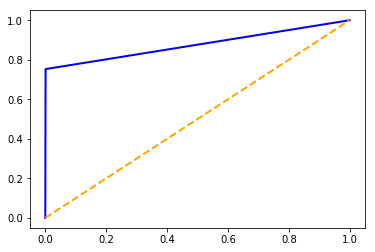

In [31]:
print("MSE for training set: ", mean_squared_error(train_Y, train_pred))
print("Confusion Matrix for training set: ", evaluation_train.matrix())
fpr, tpr, _ = roc_curve(train_Y, train_pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color = "blue", lw = lw)
plt.plot([0, 1], [0, 1], color = "orange", lw = lw, linestyle = "--")
print("AUC Score: ", auc(fpr, tpr))

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


MSE for testing set:  0.00975
Confusion Matrix for test set:  === Confusion Matrix ===

     a     b   <-- classified as
 15584    41 |     a = neg
   115   260 |     b = pos

AUC Score:  0.8453546666666667


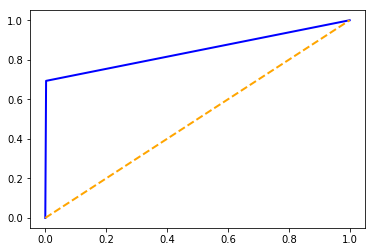

In [30]:
print("MSE for testing set: ", mean_squared_error(test_Y, test_pred))
print("Confusion Matrix for test set: ", evaluation_test.matrix())
fpr, tpr, _ = roc_curve(test_Y, test_pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color = "blue", lw = lw)
plt.plot([0, 1], [0, 1], color = "orange", lw = lw, linestyle = "--")
print("AUC Score: ", auc(fpr, tpr))

### f) SMOTE to balance data

In [32]:
train_smote_df = pd.read_csv("train.csv")
test_smote_df = pd.read_csv("test.csv")

In [34]:
from imblearn.over_sampling import SMOTE

#### Using smote to upsample data

In [36]:
smote = SMOTE(random_state = 5, sampling_strategy = 0.5)

In [38]:
new_sample = smote.fit_sample(train_smote_df.drop(["class"], axis = 1), train_smote_df["class"])

In [48]:
new_sample_train_feat = pd.DataFrame(new_sample[0], columns = train_smote_df.drop(["class"], axis = 1).columns)

In [49]:
new_sample_train_label = pd.DataFrame(new_sample[1], columns = (["class"]))

In [54]:
new_sample_train = pd.concat([new_sample_train_feat, new_sample_train_label], axis = 1)

In [56]:
new_sample_train["class"].value_counts()

neg    59000
pos    29500
Name: class, dtype: int64

In [59]:
new_sample_train.to_csv("smote_train.csv", index=True)

In [61]:
smote_train = loader.load_file("smote_train.csv")
smote_train.class_is_last()

In [62]:
classifier_smote = Classifier(classname="weka.classifiers.trees.LMT")
evaluation_smote_cv = Evaluation(smote_train)
evaluation_smote_cv.crossvalidate_model(classifier = classifier_smote, data = smote_train, num_folds = 5, rnd = Random(5))


In [63]:
print("Confusion Matrix for train data: ", evaluation_smote_cv.matrix())
print("CV Error: ", evaluation_smote_cv.error_rate)
evaluation_smote_cv.area_under_roc(1)

Confusion Matrix for train data:  === Confusion Matrix ===

     a     b   <-- classified as
 58210   790 |     a = neg
   620 28880 |     b = pos

CV Error:  0.015932203389830507


0.9939363944268889

In [64]:
classifier_new_smote = Classifier(classname="weka.classifiers.trees.LMT")
classifier_new_smote.build_classifier(smote_train)

In [90]:
smote_test = loader.load_file("test_smote.csv")

In [91]:
smote_test.class_is_last()

In [94]:
evaluation_train_smote = Evaluation(smote_train)
evaluation_test_smote = Evaluation(smote_test)

In [95]:
train_pred_smote = evaluation_train_smote.test_model(classifier_new_smote, smote_train)
test_pred_smote = evaluation_test_smote.test_model(classifier_new_smote, smote_test)

In [88]:
train_labels = new_sample_train["class"].map({"pos":1, "neg":0})

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


MSE for training set:  0.0045988700564971756
Confusion Matrix for training set:  === Confusion Matrix ===

     a     b   <-- classified as
 58756   244 |     a = neg
   163 29337 |     b = pos

AUC Score:  0.9951694915254237


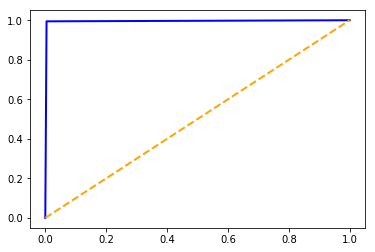

In [99]:
print("MSE for training set: ", mean_squared_error(train_labels, train_pred_smote))
print("Confusion Matrix for training set: ", evaluation_train_smote.matrix())
fpr, tpr, _ = roc_curve(train_labels, train_pred_smote)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color = "blue", lw = lw)
plt.plot([0, 1], [0, 1], color = "orange", lw = lw, linestyle = "--")
print("AUC Score: ", auc(fpr, tpr))

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


MSE for testing set:  0.0413125
Confusion Matrix for test set:  === Confusion Matrix ===

     a     b   <-- classified as
 15050   575 |     a = neg
    86   289 |     b = pos

AUC Score:  0.8669333333333334


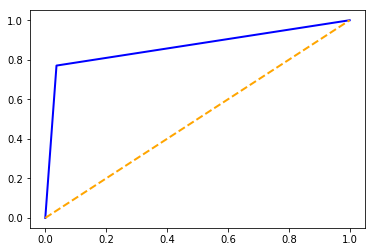

In [100]:
print("MSE for testing set: ", mean_squared_error(test_Y, test_pred_smote))
print("Confusion Matrix for test set: ", evaluation_test_smote.matrix())
fpr, tpr, _ = roc_curve(test_Y, test_pred_smote)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color = "blue", lw = lw)
plt.plot([0, 1], [0, 1], color = "orange", lw = lw, linestyle = "--")
print("AUC Score: ", auc(fpr, tpr))